## Requirements:

In [2]:
import gurobipy as gp
from gurobipy import GRB
import json
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt

## Data:

### Data collection

In [4]:
data_dir = Path("./data/question_1c")
data_dir_appliance_params = data_dir / "appliance_params.json"
data_dir_appliance_params = data_dir_appliance_params.resolve()
with open(f"{data_dir_appliance_params}", "r") as f:
    data = json.load(f)
data

{'DER': [{'DER_id': 'PV_01',
   'DER_type': 'PV',
   'max_power_kW': 3.0,
   'min_power_ratio': 0.0,
   'max_ramp_rate_up_ratio': 1.0,
   'max_ramp_rate_down_ratio': 1.0}],
 'load': [{'load_type': 'fully flexible load',
   'load_id': 'FFL_01',
   'max_load_kWh_per_hour': 3.0,
   'min_load_ratio': 0.0,
   'max_ramp_rate_up_ratio': 1.0,
   'max_ramp_rate_down_ratio': 1.0,
   'min_on_time_h': 0,
   'min_off_time_h': 0}],
 'storage': [{'storage_id': 'BESS_01',
   'storage_capacity_kWh': 6.0,
   'max_charging_power_ratio': 0.15,
   'max_discharging_power_ratio': 0.3,
   'charging_efficiency': 0.9,
   'discharging_efficiency': 0.9}]}

In [5]:
data_dir_bus_params = data_dir / "bus_params.json"
data_dir_bus_params = data_dir_bus_params.resolve()
with open(f"{data_dir_bus_params}", "r") as f:
    data2 = json.load(f)
data2

[{'bus_ID': 'Bus1',
  'import_tariff_DKK/kWh': 0.5,
  'export_tariff_DKK/kWh': 0.4,
  'max_import_kW': 1000,
  'max_export_kW': 500,
  'penalty_excess_import_DKK/kWh': 10,
  'penalty_excess_export_DKK/kWh': 10,
  'energy_price_DKK_per_kWh': [1.1,
   1.05,
   1.0,
   0.9,
   0.85,
   1.01,
   1.05,
   1.2,
   1.4,
   1.6,
   1.5,
   1.1,
   1.05,
   1.0,
   0.95,
   1.0,
   1.2,
   1.5,
   2.1,
   2.5,
   2.2,
   1.8,
   1.4,
   1.2]}]

In [6]:
data_dir_DER_production = data_dir / "DER_production.json"
data_dir_DER_production = data_dir_DER_production.resolve()
with open(f"{data_dir_DER_production}", "r") as f:
    data3 = json.load(f)
    
data3

[{'consumer_ID': 'C1',
  'DER_type': 'solar',
  'hourly_profile_ratio': [0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.05,
   0.14,
   0.21,
   0.15,
   0.12,
   0.21,
   0.25,
   0.85,
   0.75,
   0.55,
   0.43,
   0.23,
   0.05,
   0.25,
   0.25,
   0.0,
   0.0,
   0.0,
   0.0]}]

In [7]:
data_dir_usage_preferences = data_dir / "usage_preferences.json"
data_dir_usage_preferences = data_dir_usage_preferences.resolve()
with open(f"{data_dir_usage_preferences}", "r") as f:
    data4 = json.load(f)
    
data4

[{'consumer_ID': 'C1',
  'grid_preferences': None,
  'DER_preferences': None,
  'load_preferences': [{'load_id': 'FFL_01',
    'min_total_energy_per_day_hour_equivalent': None,
    'max_total_energy_per_day_hour_equivalent': None,
    'hourly_profile_ratio': [0.055,
     0.04,
     0.04,
     0.04,
     0.075,
     0.48,
     0.76,
     0.8,
     0.63,
     0.22,
     0.25,
     0.35,
     0.3,
     0.28,
     0.45,
     0.65,
     0.78,
     0.9,
     0.98,
     0.88,
     0.075,
     0.15,
     0.075,
     0.055]}],
  'storage_preferences': [{'storage_id': 'BESS_01',
    'initial_soc_ratio': 0.5,
    'final_soc_ratio': 0.5}],
  'heat_pump_preferences': None}]

In [8]:
def get_param(data, key, category=None, idx=0, subcategory=None, subidx=0):
    """
    General function to access a value from a (possibly nested) data dictionary.

    Args:
        data (dict or list): The loaded JSON dictionary or list of dicts.
        key (str): The key to access.
        category (str or None): The category (e.g., "DER", "load", "storage") if nested, else None.
        idx (int): Index in the list (default 0).
        subcategory (str or None): Optional subcategory key (e.g., "load_preferences").
        subidx (int): Index in the subcategory list (default 0).

    Returns:
        The value for the requested key, or None if not found.
    """
    try:
        if category and subcategory:
            return data[category][idx][subcategory][subidx][key]
        elif category:
            return data[category][idx][key]
        elif subcategory:
            return data[idx][subcategory][subidx][key]
        elif isinstance(data, list):
            return data[idx][key]
        else:
            return data[key]
    except (KeyError, IndexError, TypeError):
        print(f"Could not find {key} in the provided path.")
        return None

# Example usage:
# For data4 structure:
# get_param(data4, "hourly_profile_ratio", subcategory="load_preferences")

In [9]:
"Solar Power"
max_power_solar = get_param(data, "max_power_kW", category="DER")
min_power_ratio = get_param(data, "min_power_ratio", category="DER")
max_ramp_up_rate_solar  = get_param(data, "max_ramp_rate_up_ratio", category="DER")
max_ramp_down_rate_solar = get_param(data, "max_ramp_rate_down_ratio", category="DER")

#------------------------------------
"Flexible Load"
max_FFL = get_param(data, "max_load_kWh_per_hour", category="load")
min_FFL = get_param(data, "min_load_ratio", category="load")
max_ramp_up_rate_FFL = get_param(data, "max_ramp_rate_up_ratio", category="load")
max_ramp_down_rate_FFL = get_param(data, "max_ramp_rate_down_ratio", category="load")
min_on_time_h = get_param(data, "min_on_time_h", category="load")
min_off_time_h = get_param(data, "min_off_time_h", category="load")

#------------------------------------------------
"Battery Storage"
storage_capacity = get_param(data, "storage_capacity_kWh", category="storage")
max_charging_power_ratio = get_param(data, "max_charging_power_ratio", category="storage")
max_discharging_power_ratio = get_param(data, "max_discharging_power_ratio", category="storage")
charging_efficiency = get_param(data, "charging_efficiency", category="storage")
discharging_efficiency = get_param(data, "discharging_efficiency", category="storage")


### Data_showing

In [10]:
"Solar Power"
max_power_solar, min_power_ratio, max_ramp_up_rate_solar, max_ramp_down_rate_solar

(3.0, 0.0, 1.0, 1.0)

In [11]:
"Flexible Load"
max_FFL, min_FFL, max_ramp_up_rate_FFL , max_ramp_down_rate_FFL , min_on_time_h , min_off_time_h

(3.0, 0.0, 1.0, 1.0, 0, 0)

In [12]:
"Battery Storage"
storage_capacity, max_charging_power_ratio, max_discharging_power_ratio, charging_efficiency, discharging_efficiency 

(6.0, 0.15, 0.3, 0.9, 0.9)

In [13]:

price_import = get_param(data2, "import_tariff_DKK/kWh")  
price_export = get_param(data2, "export_tariff_DKK/kWh")  
max_import = get_param(data2, "max_import_kW")  
max_export = get_param(data2, "max_export_kW")  
penalty_excess_import = get_param(data2, "penalty_excess_import_DKK/kWh") 
penalty_excess_export = get_param(data2, "penalty_excess_export_DKK/kWh")  


electricity_price = get_param(data2, "energy_price_DKK_per_kWh")  

In [14]:
price_import, price_export, max_import, max_export, penalty_excess_import, penalty_excess_export

(0.5, 0.4, 1000, 500, 10, 10)

In [15]:
electricity_price

[1.1,
 1.05,
 1.0,
 0.9,
 0.85,
 1.01,
 1.05,
 1.2,
 1.4,
 1.6,
 1.5,
 1.1,
 1.05,
 1.0,
 0.95,
 1.0,
 1.2,
 1.5,
 2.1,
 2.5,
 2.2,
 1.8,
 1.4,
 1.2]

In [16]:
Solar_CF = get_param(data3,"hourly_profile_ratio")
Solar_CF

[0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.05,
 0.14,
 0.21,
 0.15,
 0.12,
 0.21,
 0.25,
 0.85,
 0.75,
 0.55,
 0.43,
 0.23,
 0.05,
 0.25,
 0.25,
 0.0,
 0.0,
 0.0,
 0.0]

In [17]:
load_profile_consumer = get_param(data4, "hourly_profile_ratio", subcategory="load_preferences")
SOC_initial = get_param(data4, "initial_soc_ratio", subcategory="storage_preferences")
SOC_final = get_param(data4, "final_soc_ratio", subcategory="storage_preferences")


In [18]:
SOC_initial, SOC_final

(0.5, 0.5)

In [19]:
load_profile_consumer

[0.055,
 0.04,
 0.04,
 0.04,
 0.075,
 0.48,
 0.76,
 0.8,
 0.63,
 0.22,
 0.25,
 0.35,
 0.3,
 0.28,
 0.45,
 0.65,
 0.78,
 0.9,
 0.98,
 0.88,
 0.075,
 0.15,
 0.075,
 0.055]

In [20]:
t = range(len(Solar_CF))
t

range(0, 24)

In [21]:
# Instead of using a beta it id going to be set a penalty for the discomfort on 25% of the electricity price
penalty_discomfort = electricity_price  # €/Mwh
for _ in range(len(penalty_discomfort)):
    penalty_discomfort[_] *= 1.7

penalty_discomfort

[1.87,
 1.785,
 1.7,
 1.53,
 1.4449999999999998,
 1.7169999999999999,
 1.785,
 2.04,
 2.38,
 2.72,
 2.55,
 1.87,
 1.785,
 1.7,
 1.615,
 1.7,
 2.04,
 2.55,
 3.57,
 4.25,
 3.74,
 3.06,
 2.38,
 2.04]

## Optimization model:

In [ ]:
def prosumer_optimization_with_battery_factor(price_import, price_export, electricity_price, penalty_excess_import, penalty_excess_export, battery_cost_per_unit):
    """
    Prosumer optimization model with integer battery multiplier and linear cost for battery units.
    Implements constraint: imported energy must cover battery charging (with efficiency).
    """
    model = gp.Model("Prosumer_Continuous_BatteryFactor")

    # Variable entera: factor multiplicador de batería (número de baterías)
    battery_factor = model.addVar(vtype=GRB.INTEGER, lb=1, ub=GRB.INFINITY, name="battery_factor")  # Ejemplo: entre 1 y 5 unidades

    # Decision variables
    x_imports = model.addVars(t, name="imported_power_kW", lb=0, ub=GRB.INFINITY)
    x_exports = model.addVars(t, name="exported_power_kW", lb=0, ub=GRB.INFINITY)
    x_FFL = model.addVars(t, name="FFL_consumption_kW", lb=0, ub=1)
    x_solar = model.addVars(t, name="solar_power_kW", lb=0)
    z_import_excess = model.addVars(t, name="excess_import_kW", lb=0)
    z_export_excess = model.addVars(t, name="excess_export_kW", lb=0)
    delta_FFL = model.addVars(t, name="delta_FFL", lb=0, ub=GRB.INFINITY)
    SOC_t = model.addVars(t, name="SOC", lb=0)
    x_charging = model.addVars(t, name="charging_power_kW", lb=0)
    x_discharging = model.addVars(t, name="discharging_power_kW", lb=0)
    obj_var = model.addVar(name="objective_value")

    # Hourly constraints
    for i in t:
        # FFL min/max
        model.addConstr(x_FFL[i] * max_FFL >= min_FFL, name=f"FFL_min_{i}")
        model.addConstr(x_FFL[i] * max_FFL <= max_FFL, name=f"FFL_max_{i}")

        # Solar production limit
        model.addConstr(x_solar[i] <= Solar_CF[i] * max_power_solar, name=f"solar_max_{i}")

        # Energy balance (incluye batería escalada)
        model.addConstr(
        x_imports[i] - x_exports[i] + x_solar[i] + x_discharging[i] - x_charging[i] == x_FFL[i] * max_FFL,
        name=f"energy_balance_{i}"
        )

        # Excess import/export
        model.addConstr(z_import_excess[i] >= x_imports[i] - max_import, name=f"excess_import_{i}")
        model.addConstr(z_export_excess[i] >= x_exports[i] - max_export, name=f"excess_export_{i}")

        # Discomfort per hour from load profile
        model.addConstr(delta_FFL[i] >= (x_FFL[i] - load_profile_consumer[i]) * max_FFL, name=f"discomfort_pos_{i}")
        model.addConstr(delta_FFL[i] >= (load_profile_consumer[i] - x_FFL[i]) * max_FFL, name=f"discomfort_neg_{i}")

        # SOC bounds and dynamics escalados por battery_factor
        model.addConstr(SOC_t[i] <= storage_capacity * battery_factor, name=f"SOC_max_{i}")
        model.addConstr(x_charging[i] <= max_charging_power_ratio * storage_capacity * battery_factor, name=f"charging_limit_{i}")
        model.addConstr(x_discharging[i] <= max_discharging_power_ratio * storage_capacity * battery_factor, name=f"discharging_limit_{i}")

        # Imported and exported energy must cover battery charging (with efficiency)
        model.addConstr(x_imports[i] >= x_charging[i] / charging_efficiency, name=f"import_covers_charging_{i}")

        model.addConstr(x_exports[i] <= x_discharging[i] * discharging_efficiency, name=f"exports_covers_charging_{i}")

        if i == 0:
            model.addConstr(SOC_t[i] == SOC_initial * storage_capacity * battery_factor, name="initial_soc")
        if i == len(t)-1:
            model.addConstr(SOC_t[i] == SOC_final * storage_capacity * battery_factor, name="final_soc")

        if i > 0:
            # Ramp constraints for FFL + Solar
            model.addConstr(
                (x_FFL[i] * max_FFL) - (x_FFL[i-1] * max_FFL) <= max_ramp_up_rate_FFL * max_FFL,
                name=f"FFL_ramp_up_{i}"
            )
            model.addConstr(
                (x_FFL[i-1] * max_FFL) - (x_FFL[i] * max_FFL) <= max_ramp_down_rate_FFL * max_FFL,
                name=f"FFL_ramp_down_{i}"
            )
            model.addConstr(
                x_solar[i] - x_solar[i-1] <= max_ramp_up_rate_solar * max_power_solar,
                name=f"solar_ramp_up_{i}"
            )
            model.addConstr(
                x_solar[i-1] - x_solar[i] <= max_ramp_down_rate_solar * max_power_solar,
                name=f"solar_ramp_down_{i}"
            )
            # SOC dynamics escalados
            model.addConstr(
                SOC_t[i] == SOC_t[i-1] + (x_charging[i - 1]) - (x_discharging[i - 1]),
                name=f"SOC_dynamics_{i}"
            )
    
    # Fix: wrap generator in gp.quicksum before multiplying
    expr = gp.quicksum(
        (-price_import - electricity_price[i]) * x_imports[i]
        - penalty_excess_import * z_import_excess[i]
        + (electricity_price[i] - price_export) * x_exports[i]
        - penalty_excess_export * z_export_excess[i]
        - penalty_discomfort[i]*delta_FFL[i]
        for i in t
    )
    expr = expr * 0.7 - battery_cost_per_unit/(10*365) * battery_factor # 0.7 means for the risk, 10*365 is due to the lifetime for the payback
    model.addConstr(obj_var == expr, name="objective_definition")
    #model.addConstr(obj_var >= (3595/7)*storage_capacity/(365), name="objective_limit")
    #model.addConstr(obj_var <= 10, name="objective_limit")

    # Objective: maximizar beneficio menos coste lineal de baterías
    model.setObjective(obj_var, GRB.MAXIMIZE)

    model.optimize()

    return model, x_imports, x_exports, x_FFL, x_solar, delta_FFL, SOC_t, x_charging, x_discharging, battery_factor


In [ ]:
# Run the optimization and get the variables
model, x_imports, x_exports, x_FFL, x_solar, delta_FFL, SOC_t, x_charging, x_discharging, battery_factor = prosumer_optimization_with_battery_factor(
    price_import, price_export, electricity_price,
    penalty_excess_import, penalty_excess_export,
    battery_cost_per_unit = (3595/7)*storage_capacity #price of a 7kwh battery
)

Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (win64 - Windows 11.0 (22631.2))

CPU model: Intel(R) Core(TM) i5-1035G4 CPU @ 1.10GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 430 rows, 242 columns and 1050 nonzeros
Model fingerprint: 0xb5b10bc2
Variable types: 241 continuous, 1 integer (0 binary)
Coefficient statistics:
  Matrix range     [7e-01, 7e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-01, 1e+03]
Presolve removed 168 rows and 11 columns
Presolve time: 0.00s
Presolved: 262 rows, 231 columns, 777 nonzeros
Variable types: 230 continuous, 1 integer (0 binary)

Root relaxation: objective 5.755639e+00, 200 iterations, 0.01 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0    5.75564    0    1      

In [77]:
# Print all outputs per hour
print("Hour | Import(kW) | Export(kW) | FFL(kW) | Solar(kW) | Delta_FFL | SOC(kWh) | Charging(kW) | Discharging(kW) | Excess Import(kW) | Excess Export(kW)")
for i in t:
    print(f"{i:>4} | "
          f"{x_imports[i].X:>10.3f} | "
          f"{x_exports[i].X:>10.3f} | "
          f"{x_FFL[i].X * max_FFL:>7.3f} | "
          f"{x_solar[i].X:>8.3f} | "
          f"{delta_FFL[i].X:>9.3f} | "
          f"{SOC_t[i].X:>8.3f} | "
          f"{x_charging[i].X:>11.3f} | "
          f"{x_discharging[i].X:>13.3f} | "
          f"{model.getVarByName(f'excess_import_kW[{i}]').X:>15.3f} | "
          f"{model.getVarByName(f'excess_export_kW[{i}]').X:>15.3f}")
print("Optimal objective value:", model.ObjVal)
print(f"battery_factor {battery_factor.X}")

Hour | Import(kW) | Export(kW) | FFL(kW) | Solar(kW) | Delta_FFL | SOC(kWh) | Charging(kW) | Discharging(kW) | Excess Import(kW) | Excess Export(kW)
   0 |      0.000 |      0.000 |   0.000 |    0.000 |     0.165 |   51.000 |       0.000 |         0.000 |           0.000 |           0.000
   1 |      1.200 |      0.000 |   0.120 |    0.000 |     0.000 |   51.000 |       1.080 |         0.000 |           0.000 |           0.000
   2 |      1.200 |      0.000 |   0.120 |    0.000 |     0.000 |   52.080 |       1.080 |         0.000 |           0.000 |           0.000
   3 |      1.200 |      0.000 |   0.120 |    0.000 |     0.000 |   53.160 |       1.080 |         0.000 |           0.000 |           0.000
   4 |     17.000 |      0.000 |   1.700 |    0.000 |     1.475 |   54.240 |      15.300 |         0.000 |           0.000 |           0.000
   5 |     12.900 |      0.000 |   1.440 |    0.150 |     0.000 |   69.540 |      11.610 |         0.000 |           0.000 |           0.000
   6 

C:\Users\ccano\AppData\Local\Temp\ipykernel_20432\2157608039.py:24: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax1.set_ylim(0, 1000)  # Set minimum and maximum for log scale axis


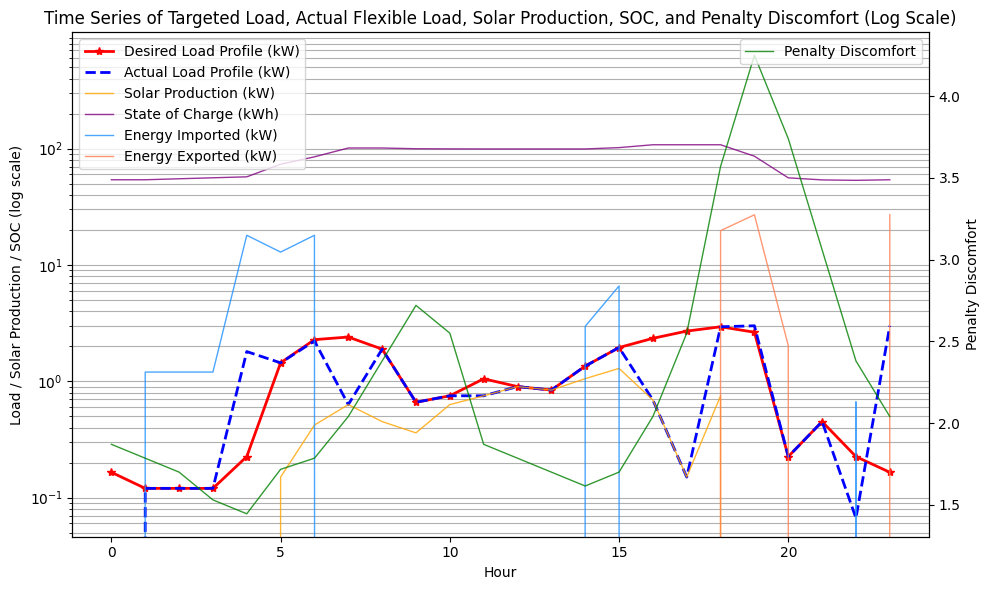

In [64]:
# Extract results after optimization
hours = list(t)
soc = [SOC_t[i].X for i in hours]
imports = [x_imports[i].X for i in hours]
exports = [x_exports[i].X for i in hours]
discomfort = [delta_FFL[i].X for i in hours]
actual_profile = [x_FFL[i].X * max_FFL for i in hours]
solar_production = [x_solar[i].X for i in hours]

import matplotlib.ticker as ticker

fig, ax1 = plt.subplots(figsize=(10,6))

# Plot desired and actual load profiles, solar production, and SOC on primary y-axis (log scale)
ax1.plot(hours, max_FFL*np.array(load_profile_consumer), label="Desired Load Profile (kW)", marker="*", color='red', linewidth=2, alpha=1)
ax1.plot(hours, np.array(actual_profile), label="Actual Load Profile (kW)", linestyle='--', color='blue', linewidth=2, alpha=1)
ax1.plot(hours, solar_production, label="Solar Production (kW)", linestyle='-', color='orange', linewidth=1, alpha=0.8)
ax1.plot(hours, soc, label="State of Charge (kWh)", linestyle='-', color='purple', linewidth=1, alpha=0.8)
ax1.plot(hours, imports, label="Energy Imported (kW)", color='dodgerblue', linewidth=1, alpha=0.8)
ax1.plot(hours, exports, label="Energy Exported (kW)", color='coral', linewidth=1, alpha=0.8)
ax1.set_xlabel("Hour")
ax1.set_ylabel("Load / Solar Production / SOC (log scale)")
ax1.set_yscale('log')
ax1.set_ylim(0, 1000)  # Set minimum and maximum for log scale axis
ax1.set_yticks([0.1, 1, 10, 100])
ax1.legend(loc="upper left")
ax1.grid(True, which='both', axis='y')

# Create secondary y-axis for penalty_discomfort
ax2 = ax1.twinx()
ax2.plot(hours, penalty_discomfort, label="Penalty Discomfort", color='green', linewidth=1, alpha=0.8)
ax2.set_ylabel("Penalty Discomfort")
ax2.legend(loc="upper right")

plt.title("Time Series of Targeted Load, Actual Flexible Load, Solar Production, SOC, and Penalty Discomfort (Log Scale)")
plt.tight_layout()
plt.show()

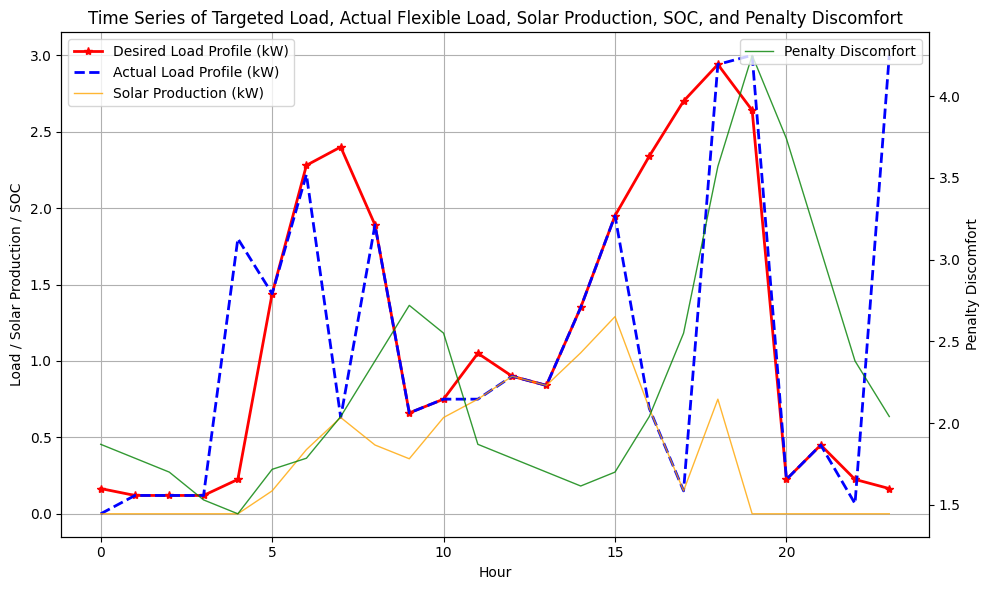

In [65]:
fig, ax1 = plt.subplots(figsize=(10,6))

# Plot desired and actual load profiles, solar production, and SOC on primary y-axis
ax1.plot(hours, max_FFL*np.array(load_profile_consumer), label="Desired Load Profile (kW)", marker="*", color='red', linewidth=2, alpha=1)
ax1.plot(hours, np.array(actual_profile), label="Actual Load Profile (kW)", linestyle='--', color='blue', linewidth=2, alpha=1)
ax1.plot(hours, solar_production, label="Solar Production (kW)", linestyle='-', color='orange', linewidth=1, alpha=0.8)
ax1.set_xlabel("Hour")
ax1.set_ylabel("Load / Solar Production / SOC")
ax1.legend(loc="upper left")
ax1.grid(True)

# Create secondary y-axis for penalty_discomfort
ax2 = ax1.twinx()
ax2.plot(hours, penalty_discomfort, label="Penalty Discomfort", color='green', linewidth=1, alpha=0.8)
ax2.set_ylabel("Penalty Discomfort")
ax2.legend(loc="upper right")

plt.title("Time Series of Targeted Load, Actual Flexible Load, Solar Production, SOC, and Penalty Discomfort")
plt.tight_layout()
plt.show()